# Big Tech Stock Predictor

The goal of this project is to use AAPL stock as a tool to leverage different machine learning and deep learning regressors to predict the stock price / movement across an array of intervals to see how accurate ML / DL models can be.

**What is being predicted?**

The predicted feature for this research is the adjusted close as this is the standard for comparing price of a security irregardless of security splits / other external factors, and thus this will be the target feature that the regressors will be trying to estimate.

# Data Pre-Processing

In this step, we are preparing the data to be used in training the models.

Note that feature engineering has already been performed manually on this dataset to add in extra columns, and thus the resulting CSV file is already engineered. I added in manually the column for Earnings (0 representing non-earnings the next day and 1 representing an earnings report the following day), and also predicted EPS (earnings per share) and actual EPS columns.

Citation for AAPL stock inital data: https://www.kaggle.com/datasets/evangower/big-tech-stock-prices/?select=AAPL.csv

Citation for Earnings, Predicted and Actual EPS data: https://www.alphaquery.com/stock/AAPL/earnings-history

Note also that our target variable - actual adj close - varies depending on the time frame we are trying to predict as it shifts depending on how far out we are attempting to forecast.

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt

df_aapl = pd.read_csv('AAPL.csv')

df_aapl = df_aapl.dropna(subset=['Date'])

# Convert the 'Date' column to datetime type
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Extract the timestamp from the datetime and convert it to float
df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# Visualization of features

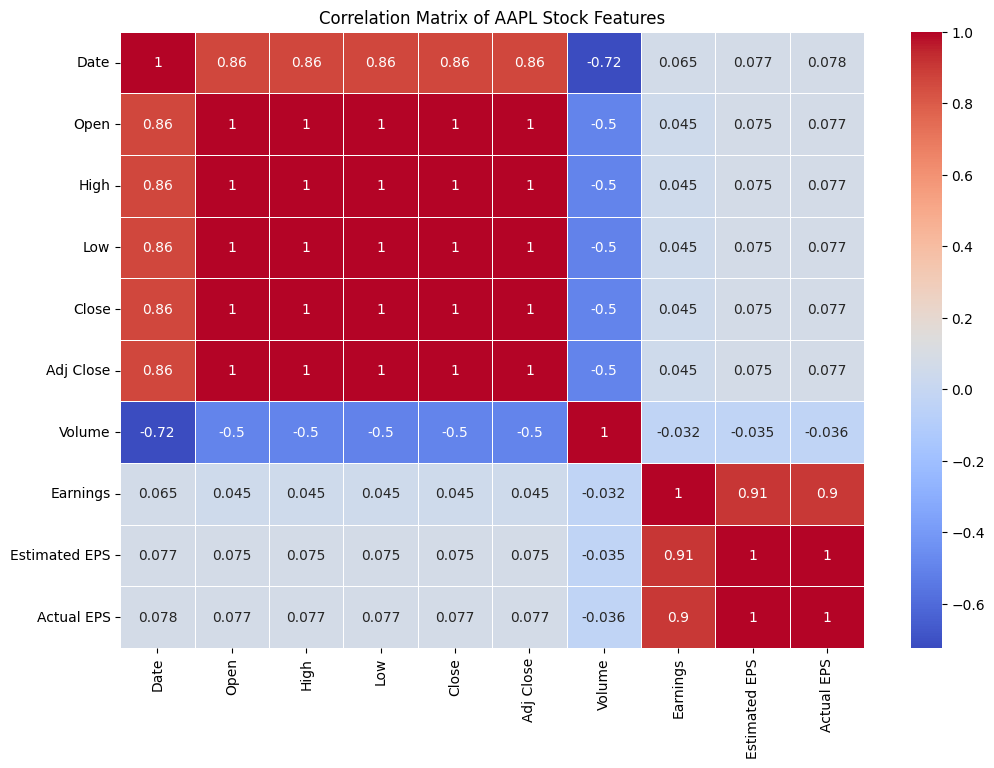

In [84]:
correlation_matrix = df_aapl.corr()

plt.figure(figsize=(12, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)

plt.title('Correlation Matrix of AAPL Stock Features')
plt.show()

# Linear Regression Model

**Next Day Prediction (non-earnings eve)**

Uses non-earnings eve rows (ie rows where the next day is not an earnings day) to forecast AAPL stock price predictions for the next day

Overall size of predictions for a day (non-earnings) out: 648
Overall modified Accuracy
0.9735299759438153
Mean Squared Error (adj price in dollars amount off): 2.2487608189847177
Custom Prediction for next day, actual adj close is 51.719452
Linear Regression model predicted for next day: [53.92375406]
Accuracy of Custom Prediction:
[95.73796324]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


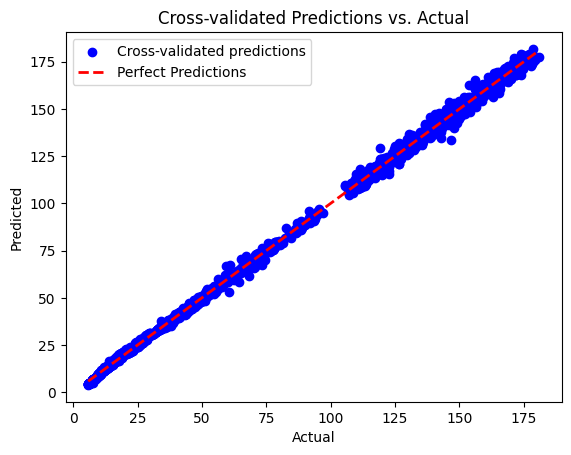

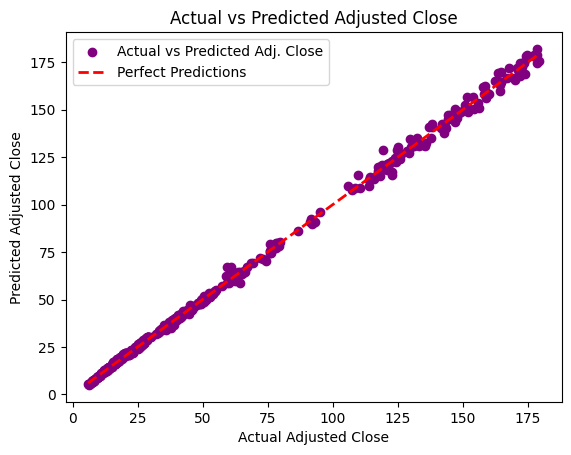

In [86]:
# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (non-earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next day, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next day: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Analysis of non-earnings eve results**

In the above graphs, we can see a very interested spread of our model's predictions. In the Actual vs Predicted Adjusted Close graph, we can see that the linear regression model is quite accurate at the start of the actual adjusted close price, but as the adjusted close price goes on (and thus time also increases due to correlation), we see that the model is less accurate with its predictions straying further from the perfect prediction trend line. This phenomena also extends to the accuracy of the cross-validated predictions as well, and can be best explained through the increase of market volatility over recent years.

Market volatility will likely become even more prevalent as time goes on, and thus is something that must be accounted for in making predictions. However, it is interesting that its visualization is so readily obvious in the above graphs.

**Next Day Prediction (earnings eve)**

Overall size of predictions for a day (earnings) out: 7
Overall modified Accuracy
0.97565838829552
Mean Squared Error (adj price in dollars amount off): 4.685496522072697
Custom Prediction for next earnings day, actual adj close is 49.889595
Linear Regression model predicted for next earnings day: [53.9279945]
Accuracy of Custom Prediction:
[91.90532716]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


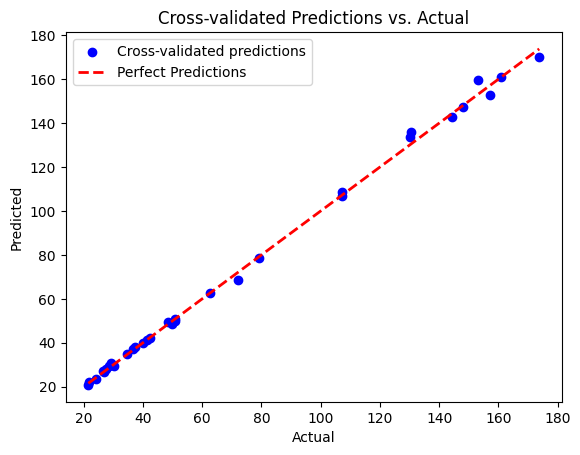

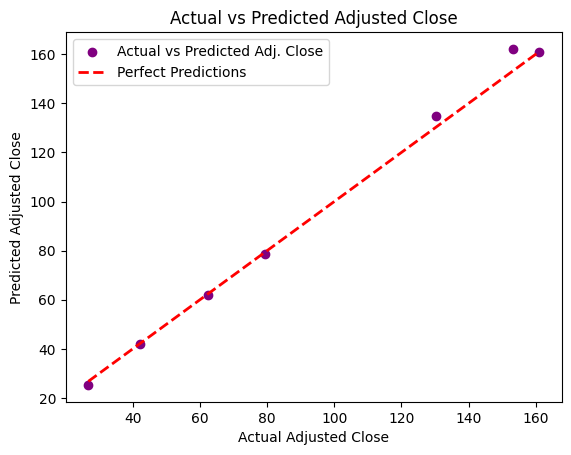

In [87]:
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adjusted close (ie what we are trying to predict)
# to be the next day's adjusted close
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        pd.concat([selected_rows, row], ignore_index=True)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          next_row_df = pd.DataFrame(df_aapl.loc[index + 1]).transpose()
          selected_rows = pd.concat([selected_rows, next_row_df], ignore_index=True)

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame or list of tuples with predicted and actual values
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_aapl, predicted)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 11/01/2018 predicting 11/02/2018 adj close)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next earnings day, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next earnings day: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

**Analysis of earnings eve results**

Similar to the above non-earnings eve results, we can see that our linear regression model performs much more accurately when the actual adjusted close price is lower, and becomes more erratic as the share price increases, ie time goes on. Besides having much fewer data points to work with, earnings is particularly interesting as it is readily known that even if a company beats earnings estimates, the stock price can still decrease based on the whims of the market and other external factors, thus, achieving accuracy with the linear regression model for this application is difficult but intriguing. As in recent years past, with increased market volatility we can see this trend demonstrated yet again across both the cross-validated prediction and predicted adjusted close vs actual.

**Next Month Stock Prediction (non-earnings)**

Note that the shift for the monthly data is not quite as linear as simply shifting over by 1 for the subsequent day due to varying month length. Instead, an average has been taken between different months to use an approximation of the number of market open days that elaspses in a monthly interval. An approximation of 22 market open days between monthly intervals was found to best estimate this shift.


Overall size of predictions for a month out: 644
Overall modified Accuracy
0.9265594358574339
Mean Squared Error (adj price in dollars amount off): 31.808571025890323
Custom Prediction for next month, actual adj close is 131.159927
Linear Regression model predicted for next month: [148.61060118]
Accuracy of Custom Prediction:
[86.6951175]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


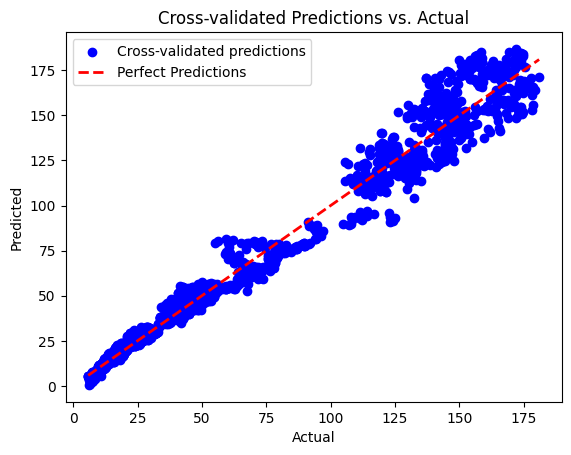

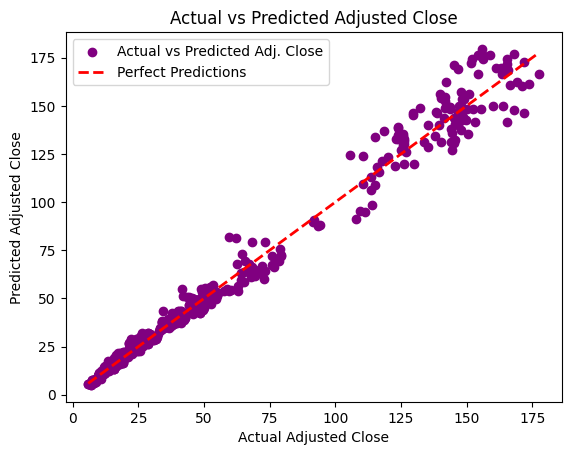

In [88]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later to simulate a month
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-22)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a month out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2022-05-17)
custom_values = np.array([[148.860001,149.770004,146.679993,149.240005,78336300,0]])

# This would be the date (2022-06-17)
actual_adj_value = 131.159927

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example (2022-05-17) predicting (2022-06-17)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next month, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next month: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Year Stock Prediction (non-earnings)**

To determine the 250 value as the proper amount to shift, I used the .tail() method to see the last values of the df, and adjusted the amount so that the tail end of the data cut off as close to 1 year earlier as possible, ensuring the closest possible business day shift for the dataset. Also manual testing was performed in Excel to ensure 250 provided a realistic shift to simulate a year.

Overall size of predictions for a year out: 599
Overall modified Accuracy
0.7464694371316677
Mean Squared Error (adj price in dollars amount off): 232.01896536416294
Custom Prediction for next year, actual adj close is 51.923771
Linear Regression model predicted for next year: [211.27417307]
Accuracy of Custom Prediction:
[-206.89296829]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


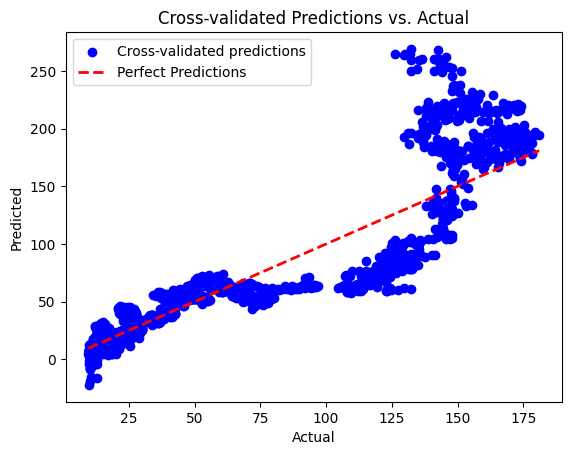

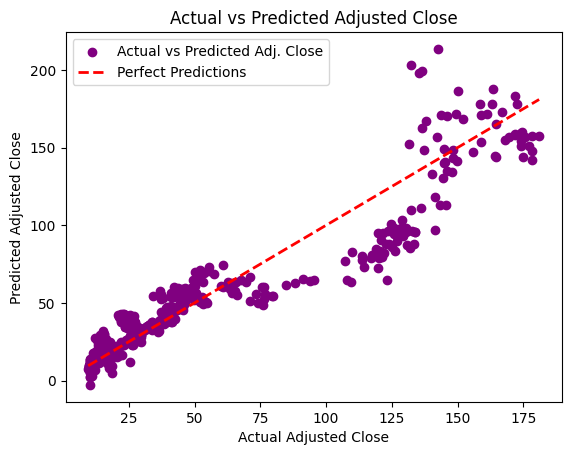

In [89]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately one year (250 business market open) days later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-250)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a year out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (adj price in dollars amount off): {mse}")

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
# custom_values = np.array([[54.200001,54.297501,53.507500,53.759998,104639200,0]])

custom_values = np.array([[181.27,183.89,180.97,183.79,54274900,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next year: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Cross-validated Predictions vs. Actual')
plt.legend()
plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Decade Stock Prediction (non-earnings)**

The 2520 value as the approximation for business days in a decade was found to be most suitable for this dataset using a similar method as the yearly shift estimate in the above cell.

train_set
          Date       Open       High        Low      Close  Adj Close  \
0   2010-01-04   7.622500   7.660714   7.585000   7.643214   6.515213   
1   2010-01-05   7.664286   7.699643   7.616071   7.656429   6.526476   
2   2010-01-06   7.656429   7.686786   7.526786   7.534643   6.422664   
3   2010-01-07   7.562500   7.571429   7.466071   7.520714   6.410790   
4   2010-01-08   7.510714   7.571429   7.466429   7.570714   6.453412   
..         ...        ...        ...        ...        ...        ...   
668 2012-08-27  24.285357  24.316786  24.055000  24.131430  20.658375   
669 2012-08-28  24.106428  24.146429  23.952499  24.100000  20.631475   
670 2012-08-29  24.116072  24.202499  24.021429  24.052500  20.590811   
671 2012-08-30  23.951429  23.983929  23.673214  23.709642  20.297300   
672 2012-08-31  23.830357  23.878571  23.473213  23.758572  20.339184   

        Volume  Earnings  Estimated EPS  Actual EPS  Target Adj Close  \
0    493729600         0            0.0 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


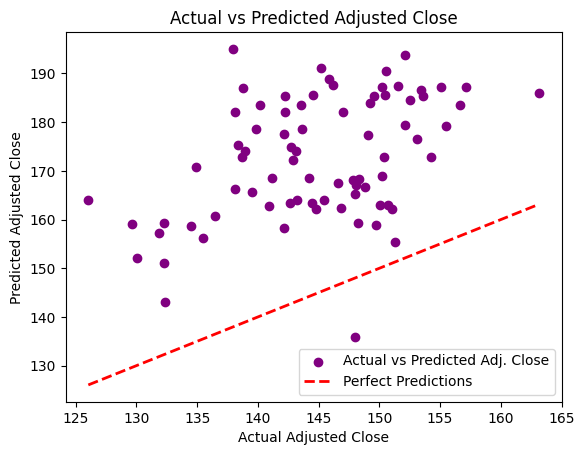

In [90]:
# # Reset the df back to pre-shift to prepare for the monthly shift
# df_aapl = pd.read_csv('AAPL.csv')

# df_aapl = df_aapl.dropna(subset=['Date'])

# # Convert the 'Date' column to datetime type
# # df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# # # Extract the timestamp from the datetime and convert it to float
# # df_aapl['Date'] = df_aapl['Date'].apply(lambda x: x.timestamp())

# # Assign the target adj close (what we are trying to predict)
# # to be the adjusted close of the row approximately 2520 business (market open) days later to simulate a decade later
# df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# # Drop the last row to handle NaN values created by the shift
# df_aapl = df_aapl.dropna()

# # Only keep the  non-earnings rows (ie where Earnings != 1)
# df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# # Separate the features (X) and target variable (y) which is the target adjusted close
# # see report / text comments for further explanation
# y_aapl = df_aapl_non['Target Adj Close']

# # Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# # since we are not considered earnings per share (EPS) estimates
# X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)


# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

df_aapl['Target Date'] = df_aapl['Date'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl_non = df_aapl.dropna()

# y_aapl = df_aapl_non['Target Adj Close']

# # Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# # since we are not considered earnings per share (EPS) estimates
# X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Specify the date to split the data
split_date = '2012-9-01'

# Convert the date column to datetime format if needed
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < split_date]
print("train_set")
print(train_set)
test_set = df_aapl[df_aapl['Date'] >= split_date]
print("test_set")
print(test_set)

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS', 'Target Date'], axis=1)

y_test_lr = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS', 'Target Date'], axis=1)







# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
linear_regression_model = LinearRegression()

# Perform cross-validated predictions
predicted = cross_val_predict(linear_regression_model, X_aapl, y_aapl, cv=10)

# Train the regression model on the scaled training data
linear_regression_model.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
predictions = linear_regression_model.predict(X_test_scaled)

df_aapl_total = pd.read_csv('AAPL.csv')

df_aapl_total = df_aapl_total.dropna(subset=['Date'])

X_aapl_total = df_aapl_total.drop(['Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Create a new value for all predictions
X_total_scaled = scaler.transform(X_aapl_total)

print(f"Len of X_aapl: {len(X_aapl_total)}")
print(f"Len of X_aapl_scaled: {len(X_total_scaled)}")

# Create a DataFrame with cross-validated predictions
results_df_lr = pd.DataFrame({'Predicted': predictions, 'Actual': y_test_lr})
print("Actual RESULTS_DF_LR WE CARE ABOUT")
print(len(results_df_lr))
print("results_df below!!")
print(results_df_lr)

# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test_lr))

predictions_total = linear_regression_model.predict(X_total_scaled)
results_total_df_lr = pd.DataFrame({'Predicted': predictions_total})


# print("incoming results for looop")
# for i in range(len(predictions_total)):
#   print(predictions_total[i])

print(f"Overall size of predictions for a decade out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Evaluate the performance of the regression model

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2012-02-14)
# custom_values = np.array([[18.023571,18.198570,17.928572,18.195000,460398400,0]])

custom_values = np.array([[66.945000,68.139999,66.830002,67.864998,137310400,0]])


# This would be the date (2022-02-14)
actual_adj_value = 168.119446

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the linear regression model
# for our custom values (test example 2012-02-14 predicting 2022-02-14
custom_predictions = linear_regression_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next decade, actual adj close is {actual_adj_value}")
print(f"Linear Regression model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the results of cross-validated predictions
# plt.scatter(y_aapl, predicted, color='blue', label='Cross-validated predictions')
# plt.plot([y_aapl.min(), y_aapl.max()], [y_aapl.min(), y_aapl.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.title('Cross-validated Predictions vs. Actual')
# plt.legend()
# plt.show()

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df_lr['Actual'], results_df_lr['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df_lr['Actual'].min(), results_df_lr['Actual'].max()], [results_df_lr['Actual'].min(), results_df_lr['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Random Forest Regressor

**Next Day Prediction (non-earnings eve)**

Uses non-earnings eve rows (ie rows where the next day is not an earnings day) to forecast AAPL stock price predictions for the next day

MSE of RF Regressor (adj price in dollars amount off): 2.2283300432001845
2.2283300432001845
Overall size of predictions for a day (non-earnings) out: 648
Overall modified Accuracy
0.9825111462506166
Custom Prediction for next day, actual adj close is 51.719452
Random Forest model predicted for next day: [53.10131136]
Accuracy of Custom Prediction:
[97.32816317]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


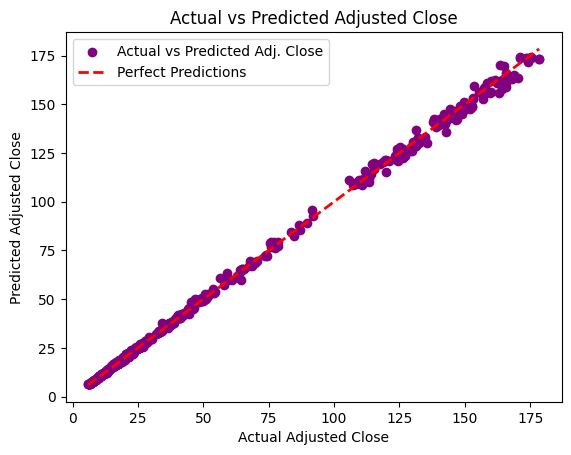

In [92]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a day (non-earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (10/23/2018)
custom_values = np.array([[53.957500,55.812500,53.674999,55.682499,155071200,0]])

# This would be the next day after the above date (10/24/2018)
actual_adj_value = 51.719452

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 10/23/2018 predicting 10/24/2018)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next day, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next day: {custom_predictions}")


print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Day Prediction (earnings eve)**
Uses earnings eve rows and subsequent earnings day rows as pairs to predict the earnings day adjusted price based upon earnings eve

MSE of RF Regressor (adj price in dollars amount off): 283.72808656438986
283.72808656438986
Overall size of predictions for a day out (earnings) out: 7
Overall modified Accuracy
0.913965117711238
Accuracy of Custom Prediction:
[98.44578115]
Custom Prediction for next day (earnings), actual adj close is 49.889595
Random Forest model predicted for next day (earnings): [50.66498849]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


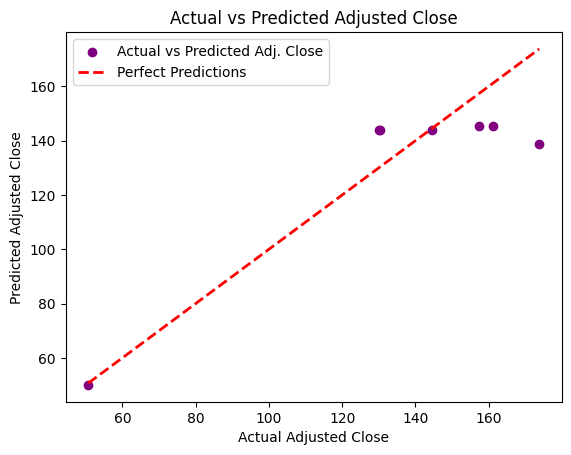

In [93]:
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adjusted close (ie what we are trying to predict)
# to be the next day's adjusted close
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-1)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Initialize an empty dataframe to store the selected rows (earnings rows and the subsequent row directly after
# so we can see the effect of the earnings results on the stock price the next day)
selected_rows = pd.DataFrame()

# Iterate through the entirety of the aapl dataframe
for index, row in df_aapl.iterrows():
    # Check if the current row has "Earnings" equal to 1
    if row['Earnings'] == 1.0:
        # Append the current row
        pd.concat([selected_rows, row], ignore_index=True)
        # Check if we are still within bounds of the df
        if ((index + 1 < len(df_aapl))):
          # If so, also append the subsequent non-earnings row to our selected rows
          next_row_df = pd.DataFrame(df_aapl.loc[index + 1]).transpose()
          selected_rows = pd.concat([selected_rows, next_row_df], ignore_index=True)

# Reset the index of the new DataFrame
selected_rows.reset_index(drop=True, inplace=True)

# Update the aapl df to contain only the selected rows relevant to earnings eve
df_aapl_earn = selected_rows

# Separate the features (X) and target variable (y)
y_aapl = df_aapl_earn['Target Adj Close']

X_aapl = df_aapl_earn.drop(['Adj Close', 'Target Adj Close', 'Date'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))


print(f"Overall size of predictions for a day out (earnings) out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# takes in open, high, low, close, volume, earnings, expected eps, actual eps
# below is an example value of earnings day eve provided as an example (11/01/2018)
custom_values = np.array([[54.762501,55.590000,54.202499,55.555000,233292800,1,0.7,0.73]])

# This would be the next day after the above date (11/02/2018)
actual_adj_value = 49.889595

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 11/01/2018 predicting 11/02/2018 adj close)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

print(f"Custom Prediction for next day (earnings), actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next day (earnings): {custom_predictions}")

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

**Next Month Prediction**

MSE of RF Regressor (adj price in dollars amount off): 23.722828155869042
23.722828155869042
Overall size of predictions for a month out: 644
Overall modified Accuracy
0.9347717640988962
Custom Prediction for next month, actual adj close is 131.159927
Random Forest model predicted for next month: [147.57885297]
Accuracy of Custom Prediction:
[87.48175121]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


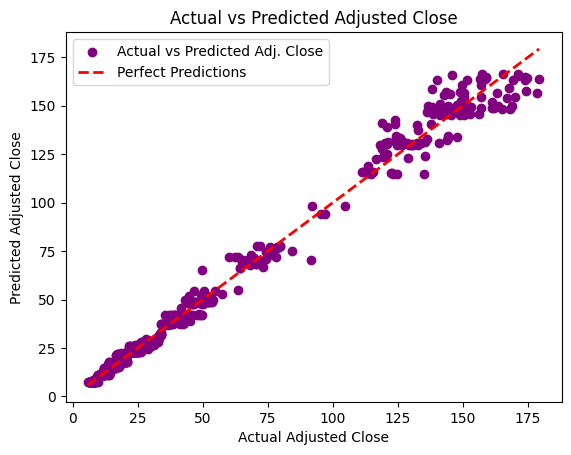

In [94]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 22 business (market open) days later to simulate a month later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-22)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a month out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2022-05-17)
custom_values = np.array([[148.860001,149.770004,146.679993,149.240005,78336300,0]])

# This would be the date (2022-06-17)
actual_adj_value = 131.159927

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the random forest regression model
# for our custom values (test example 2022-05-17 predicting 2022-06-17)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next month, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next month: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Year Prediction**

MSE of RF Regressor (adj price in dollars amount off): 109.43980441657266
109.43980441657266
Overall size of predictions for a year out: 599
Overall modified Accuracy
0.8782943950549613
Custom Prediction for next year, actual adj close is 51.923771
Random Forest model predicted for next year: [65.47522341]
Accuracy of Custom Prediction:
[73.90125535]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


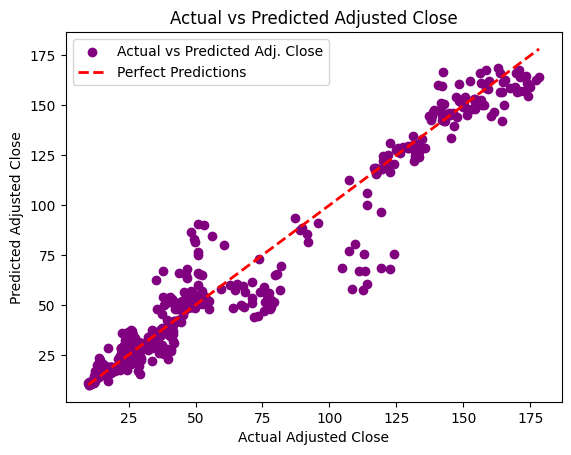

In [95]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 250 business (market open) days later to simulate a year later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-250)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the  non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considered earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a year out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
custom_values = np.array([[54.200001,54.297501,53.507500,53.759998,104639200,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next year: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


**Next Decade Prediction**

What is train set:           Date       Open       High        Low      Close  Adj Close  \
0   2010-01-04   7.622500   7.660714   7.585000   7.643214   6.515213   
1   2010-01-05   7.664286   7.699643   7.616071   7.656429   6.526476   
2   2010-01-06   7.656429   7.686786   7.526786   7.534643   6.422664   
3   2010-01-07   7.562500   7.571429   7.466071   7.520714   6.410790   
4   2010-01-08   7.510714   7.571429   7.466429   7.570714   6.453412   
..         ...        ...        ...        ...        ...        ...   
603 2012-05-24  20.566786  20.589287  20.043928  20.190001  17.210320   
604 2012-05-25  20.163929  20.208929  19.945356  20.081785  17.118074   
605 2012-05-29  20.389286  20.500000  20.189644  20.438213  17.421902   
606 2012-05-30  20.328571  20.713928  20.234285  20.684643  17.631958   
607 2012-05-31  20.740713  20.767857  20.409286  20.633215  17.588123   

        Volume  Earnings  Estimated EPS  Actual EPS  Target Adj Close  
0    493729600         0        

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


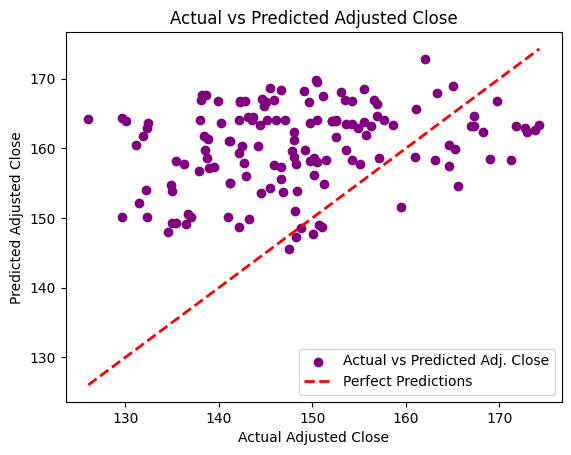

In [96]:
# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the adjusted close of the row approximately 2520 business (market open) days later to simulate a decade later
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# # Only keep the  non-earnings rows (ie where Earnings != 1)
# df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Specify the date to split the data
split_date = '2012-06-01'

# Convert the date column to datetime format if needed
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < split_date]
print(f"What is train set: {train_set}")
test_set = df_aapl[df_aapl['Date'] >= split_date]
print(f"What is test set: {test_set}")

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

y_test = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)


print(f"y_test {y_test}")
print(f"X_test {X_test}")

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Create a Random Forest Regressor
rf_regressor = RandomForestRegressor()

param_grid = {
    'n_estimators': [50, 100, 250],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best hyperparameters based on our Grid search exhaustive findings
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test_scaled)

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a decade out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))


# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2012-02-14)
# custom_values = np.array([[18.023571,18.198570,17.928572,18.195000,460398400,0]])

custom_values = np.array([[66.945000,68.139999,66.830002,67.864998,137310400,0]])

# This would be the date (2022-02-14)
actual_adj_value = 168.119446

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2012-02-14 predicting 2022-02-14)
custom_predictions = best_model.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next decade, actual adj close is {actual_adj_value}")
print(f"Random Forest model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


# Long-Short Term Memory

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 373ms/step - loss: 1.0264 - val_loss: 0.8089
Epoch 2/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - loss: 1.0540 - val_loss: 0.8230
Epoch 3/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 1.0660 - val_loss: 0.8398
Epoch 4/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - loss: 1.0654 - val_loss: 0.8728
Epoch 5/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 1.0679 - val_loss: 0.8772
Epoch 6/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - loss: 0.9883 - val_loss: 0.8593
Epoch 7/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - loss: 1.0338 - val_loss: 0.8502
Epoch 8/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 1.0701 - val_loss: 0.8673
Epoch 9/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - loss: 1.0582 - val_loss: 0.8905
Epoch 10/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - loss: 1.0264 - val_loss: 0.8969
Epoch 11/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - loss: 1.0392 - val_loss: 0.9071
Epoch 12/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - loss: 1.0654 - val_l

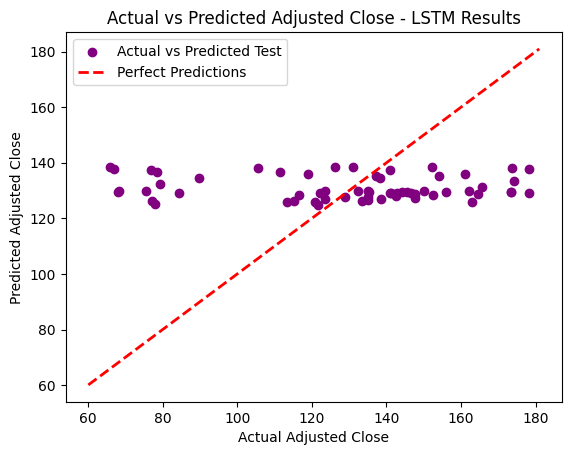

In [101]:
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Only keep the non-earnings rows (ie where Earnings != 1)
df_aapl_non = df_aapl[df_aapl['Earnings'] != 1]

# Separate the features (X) and target variable (y) which is the target adjusted close
# see report / text comments for further explanation
y_aapl = df_aapl_non['Target Adj Close']

# Note that we drop the expected EPS and actual EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# since we are not considering earnings per share (EPS) estimates
X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# Normalize the target variable
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input data to be 3D [samples, time steps, features]
time_steps = 90  # You can experiment with different time steps
X_train_reshaped = np.array([X_train_scaled[i:i+time_steps, :] for i in range(len(X_train_scaled)-time_steps+1)])
X_test_reshaped = np.array([X_test_scaled[i:i+time_steps, :] for i in range(len(X_test_scaled)-time_steps+1)])

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X_train_reshaped.shape[2])))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout layer
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train_scaled, epochs=12, batch_size=128, validation_split=0.1, verbose=1)

# Make predictions
train_predict = scaler_y.inverse_transform(model.predict(X_train_reshaped))
test_predict = scaler_y.inverse_transform(model.predict(X_test_reshaped))

# Calculate root mean squared error
train_rmse = np.sqrt(mean_squared_error(y_train.values[time_steps:], train_predict[:len(y_train) - time_steps]))
test_rmse = np.sqrt(mean_squared_error(y_test.values[time_steps:], test_predict[:len(y_test) - time_steps]))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

# Combine the training and testing predictions with the original data
all_predictions = np.concatenate([train_predict, test_predict])
all_actuals = np.concatenate([y_train.values[time_steps:], y_test.values[time_steps:]])

# Plot the actual difference between the predicted and actual adjusted close for testing data
plt.scatter(y_test.values[time_steps:], test_predict[:len(y_test) - time_steps], color='purple', label='Actual vs Predicted Test')

# Plot a diagonal line representing perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close - LSTM Results')
plt.legend()
plt.show()

# Support Vector Regression (SVR)

In [98]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl = df_aapl.dropna()

# Specify the date to split the data
split_date = '2012-06-01'

# Convert the date column to datetime format if needed
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < split_date]
print(f"What is train set: {train_set}")
test_set = df_aapl[df_aapl['Date'] >= split_date]
print(f"What is test set: {test_set}")

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

y_test = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)


# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

# SVR model
svr = SVR()

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1],
              'kernel': ['linear', 'rbf', 'poly'],
              'epsilon': [0.1, 0.2, 0.5],
              'degree': [2, 3, 4]}

grid_search = GridSearchCV(svr, param_grid, scoring='neg_mean_squared_error', cv=10, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train SVR model with best hyperparameters
best_svr = SVR(**best_params)
best_svr.fit(X_train_scaled, y_train)

# Make predictions
predictions = best_svr.predict(X_test_scaled)

# Calculate root mean squared error
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

# Evaluate the performance of the best model
mse = mean_squared_error(y_test, predictions)
print(f"MSE of RF Regressor (adj price in dollars amount off): {mse}")
print(mse)

# Create a DataFrame with cross-validated predictions
results_df = pd.DataFrame({'Predicted': predictions, 'Actual': y_test})
# Zip the predictions and test values together for ease
results_tuples = list(zip(predictions, y_test))

print(f"Overall size of predictions for a year out: {len(results_df)}")

# This accuracy represents how "off" the results are between our prediction for each row and the actual value
# of the adjusted close (using abs val)
Abs_accuracy = (1 - np.abs(1 - results_df['Predicted'] / results_df['Actual']))
print("Overall modified Accuracy")
print(np.mean(Abs_accuracy))

# Takes in open, high, low, close, volume, earnings (0 for non earnings tomorrow 1 for earnings tomorrow)
# below is an example value of a non-earnings day sequence provided as an example (2018-08-21)
custom_values = np.array([[139.899994,141.350006,138.220001,138.979996,77033700,0]])

# This would be the adj close at date 2019-08-21
actual_adj_value = 51.923771

# Scale the custom input values using a standard scaker
custom_values_scaled = scaler.transform(custom_values)

# Make predictions with the Random Forest model
# for our custom values (test example 2018-08-21 predicting 2019-08-21)
custom_predictions = best_svr.predict(custom_values_scaled)

# Print the predictions
print(f"Custom Prediction for next year, actual adj close is {actual_adj_value}")
print(f"SVR model predicted for next decade: {custom_predictions}")

print("Accuracy of Custom Prediction:")
print((1 - np.abs(1 - custom_predictions / actual_adj_value)) * 100)

# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df['Actual'], results_df['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()], [results_df['Actual'].min(), results_df['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()


What is train set:           Date       Open       High        Low      Close  Adj Close  \
0   2010-01-04   7.622500   7.660714   7.585000   7.643214   6.515213   
1   2010-01-05   7.664286   7.699643   7.616071   7.656429   6.526476   
2   2010-01-06   7.656429   7.686786   7.526786   7.534643   6.422664   
3   2010-01-07   7.562500   7.571429   7.466071   7.520714   6.410790   
4   2010-01-08   7.510714   7.571429   7.466429   7.570714   6.453412   
..         ...        ...        ...        ...        ...        ...   
603 2012-05-24  20.566786  20.589287  20.043928  20.190001  17.210320   
604 2012-05-25  20.163929  20.208929  19.945356  20.081785  17.118074   
605 2012-05-29  20.389286  20.500000  20.189644  20.438213  17.421902   
606 2012-05-30  20.328571  20.713928  20.234285  20.684643  17.631958   
607 2012-05-31  20.740713  20.767857  20.409286  20.633215  17.588123   

        Volume  Earnings  Estimated EPS  Actual EPS  Target Adj Close  
0    493729600         0        

KeyboardInterrupt: 

# Test DNN

train_set
          Date       Open       High        Low      Close  Adj Close  \
0   2010-01-04   7.622500   7.660714   7.585000   7.643214   6.515213   
1   2010-01-05   7.664286   7.699643   7.616071   7.656429   6.526476   
2   2010-01-06   7.656429   7.686786   7.526786   7.534643   6.422664   
3   2010-01-07   7.562500   7.571429   7.466071   7.520714   6.410790   
4   2010-01-08   7.510714   7.571429   7.466429   7.570714   6.453412   
..         ...        ...        ...        ...        ...        ...   
668 2012-08-27  24.285357  24.316786  24.055000  24.131430  20.658375   
669 2012-08-28  24.106428  24.146429  23.952499  24.100000  20.631475   
670 2012-08-29  24.116072  24.202499  24.021429  24.052500  20.590811   
671 2012-08-30  23.951429  23.983929  23.673214  23.709642  20.297300   
672 2012-08-31  23.830357  23.878571  23.473213  23.758572  20.339184   

        Volume  Earnings  Estimated EPS  Actual EPS  Target Adj Close  \
0    493729600         0            0.0 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 17344.7891
Epoch 2/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16987.7676 
Epoch 3/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17461.8262 
Epoch 4/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17087.5684 
Epoch 5/150


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17593.1035 
Epoch 6/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16851.4688 
Epoch 7/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16848.1992 
Epoch 8/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16798.0801 
Epoch 9/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15980.3887 
Epoch 10/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15816.4492  
Epoch 11/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15706.6436  
Epoch 12/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15316.9912 
Epoch 13/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14486.7266 
Epoch 14/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14036.7852  
Epoch 15/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13316.1865 
Epoch 16/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12006.8232  
Epoch 17/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11373.3203 
Epoch 18/150
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10636.0898  
Epoc

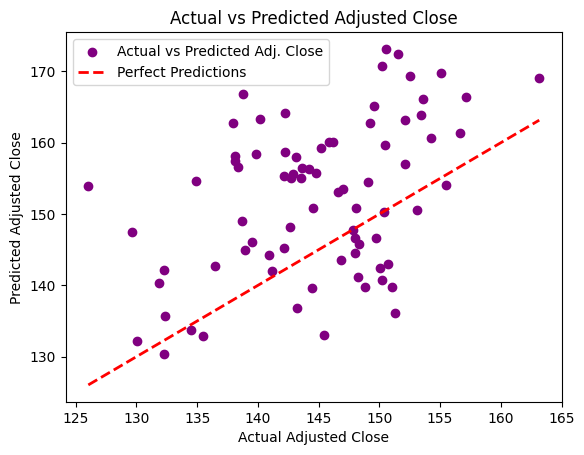

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2031 prediction: [[148.7012]]
  1/103 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [102]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = keras.Sequential();

model.add(keras.layers.Dense(6, activation='relu', input_shape=(6,)))
model.add(keras.layers.Dense(6, activation='relu'))
model.add(Dropout(0.2))  # Add dropout layer
model.add(keras.layers.Dense(6, activation='relu'))
model.add(Dropout(0.2))  # Add dropout layer
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


# Reset the df back to pre-shift to prepare for the monthly shift
df_aapl = pd.read_csv('AAPL.csv')

# Assign the target adj close (what we are trying to predict)
# to be the subsequent row's adjusted close on the following day
df_aapl['Target Adj Close'] = df_aapl['Adj Close'].shift(-2520)

df_aapl['Target Date'] = df_aapl['Date'].shift(-2520)

# Drop the last row to handle NaN values created by the shift
df_aapl_non = df_aapl.dropna()

# y_aapl = df_aapl_non['Target Adj Close']

# # Note that we drop the expected EPS and acutal EPS since this is for a non-earnings day sequence, which means that EPS data is not relevant
# # since we are not considered earnings per share (EPS) estimates
# X_aapl = df_aapl_non.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_aapl, y_aapl, test_size=0.2)

# Specify the date to split the data
split_date = '2012-9-01'

# Convert the date column to datetime format if needed
df_aapl['Date'] = pd.to_datetime(df_aapl['Date'])

# Create training and testing sets
train_set = df_aapl[df_aapl['Date'] < split_date]
print("train_set")
print(train_set)
test_set = df_aapl[df_aapl['Date'] >= split_date]
print("test_set")
print(test_set)

# Separate features (X) and target variable (y) for training and testing
y_train = train_set['Target Adj Close']
X_train = train_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS', 'Target Date'], axis=1)

y_test_dnn = test_set['Target Adj Close']
X_test = test_set.drop(['Adj Close', 'Target Adj Close', 'Date', 'Estimated EPS', 'Actual EPS', 'Target Date'], axis=1)

print("X_train set")
print(X_train)

print("y_train set")
print(y_train)

print("X_test set")
print(len(X_test))

print("y_test set")
print(y_test_dnn)

# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the scaler
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train, epochs=150, callbacks=[keras.callbacks.EarlyStopping(patience=5)])

y_pred_dnn = model.predict(X_test_scaled)

# Create a DataFrame to display actual values and predictions
results_df_dnn = pd.DataFrame({'Predicted': y_pred_dnn.flatten(), 'Actual': y_test_dnn})
print("results_df below!!")
print(results_df_dnn)

# Plot the predictions and actual results
# Plot the actual difference between the predicted and actual adjusted close
plt.scatter(results_df_dnn['Actual'], results_df_dnn['Predicted'], color='purple', label='Actual vs Predicted Adj. Close')

# Plot a diagonal line representing perfect predictions
plt.plot([results_df_dnn['Actual'].min(), results_df_dnn['Actual'].max()], [results_df_dnn['Actual'].min(), results_df_dnn['Actual'].max()], linestyle='--', color='red', linewidth=2, label='Perfect Predictions')

plt.xlabel('Actual Adjusted Close')
plt.ylabel('Predicted Adjusted Close')
plt.title('Actual vs Predicted Adjusted Close')
plt.legend()
plt.show()

# Custom predictor below
fut_data = np.array([19.675358,19.903214,19.564644,19.696787,379985200,0])
fut_data_scaled = scaler.transform(fut_data.reshape(1,6))
y_pred_fut = model.predict(fut_data_scaled.reshape(1,6), batch_size=1)
print(f"2031 prediction: {y_pred_fut}")


df_aapl_total = pd.read_csv('AAPL.csv')

df_aapl_total = df_aapl_total.dropna(subset=['Date'])

X_aapl_total = df_aapl_total.drop(['Adj Close', 'Date', 'Estimated EPS', 'Actual EPS'], axis=1)

# Create a new value for all predictions
X_total_scaled = scaler.transform(X_aapl_total)

predictions_total = model.predict(X_total_scaled)
results_total_df_dnn = pd.DataFrame({'Predicted': predictions_total.flatten()})

# print("incoming results for looop")
# for i in range(len(predictions_total.flatten())):
#   print(predictions_total[i][0])

# A Visual Between Actual Values, Linear Regressor, and DNN

How well do the trends line up?

2598
       Predicted      Actual
673   187.185368  157.109375
674   186.017282  163.159332
675   185.314502  153.585220
676   187.227702  155.052780
677   193.887243  152.117645
...          ...         ...
3266  786.563842         NaN
3267  768.898210         NaN
3268  750.108320         NaN
3269  837.044135         NaN
3270  782.895520         NaN

[2598 rows x 2 columns]
78
78
78


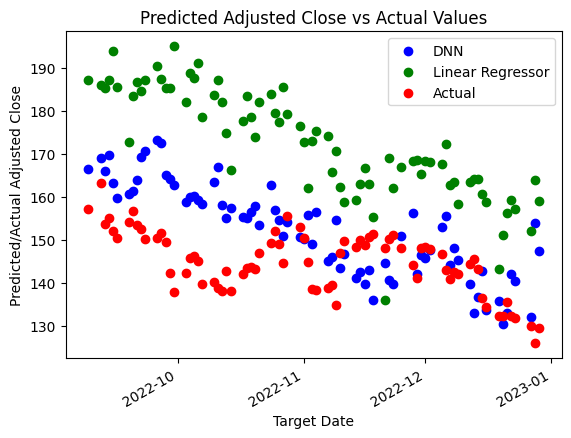

In [103]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming results_df is your DataFrame containing predicted values
results_df_dnn = pd.DataFrame({'Predicted': y_pred_dnn.flatten(), 'Actual': y_test_dnn, 'Target Date': test_set['Target Date']})

print(len(results_df_dnn['Predicted']))
# Filter out rows where 'Target Date' is not None
results_df_dnn = results_df_dnn.dropna(subset=['Target Date'])

print(results_df_lr)
results_df_lr = results_df_lr.dropna(subset=['Actual'])

# Convert 'Target Date' to datetime format
results_df_dnn['Target Date'] = pd.to_datetime(results_df_dnn['Target Date'])

# Plot only DNN predictions
plt.scatter(results_df_dnn['Target Date'], results_df_dnn['Predicted'], color='blue', label='DNN')

print(len(results_df_lr[['Predicted']]))
print(len(results_df_dnn['Target Date']))
print(len(results_df_dnn['Predicted']))
# Plot only LR predictions
plt.scatter(results_df_dnn['Target Date'], results_df_lr['Predicted'], color='green', label='Linear Regressor')

# Plot actual values
plt.scatter(results_df_dnn['Target Date'], results_df_dnn['Actual'], color='red', label='Actual')

plt.xlabel('Target Date')
plt.ylabel('Predicted/Actual Adjusted Close')
plt.title('Predicted Adjusted Close vs Actual Values')
plt.legend()

# Set x-axis ticks to show only each month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.gcf().autofmt_xdate()  # Rotate date labels for better visibility

plt.show()
